## Save or not plotted figures to EPS

In [1]:
SAVEFIGS = True

## Import

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from fractions import Fraction
from scipy import optimize
from scipy import integrate
from scipy.special import hyp2f1

rc('ps', fonttype=42)
rc('pdf', fonttype=42)
rc('text', usetex=True)

## Introduce basic class

In [3]:
class WhereAdiabatic(object):
    def __init__(self, A, Pr=0.052, dlnOmega_dlnR=1.5, cp=2.5):
        self.__A = A
        self.__Pr = Pr
        self.__dlnOmega_dlnR = dlnOmega_dlnR
        self.__cp = cp
        self.__hyp1 = self._hyp(1)
        self.__free_coef_of_func_to_minimize = (2*self.__A+2)/(2*self.__A+1) * self.__dlnOmega_dlnR**2 * self.__Pr
       
        # '2c_v / \xi^2'
        self.__coef_for_conv_xy = (self.__A+1)**2/(2*self.__A+1) * (2*2*self.__Pr*self.__dlnOmega_dlnR**2) / self.__hyp1**2
    
    @property
    def hyp1(self):
        return self.__hyp1
    
    @property
    def dlnOmega_dlnR(self):
        return self.__dlnOmega_dlnR
    
    @property
    def cp(self):
        return self.__cp
    
    def _hyp(self, arg):
        return hyp2f1(0.5, (self.__A+1)/(2*self.__A+1), (3*self.__A+2)/(2*self.__A+1), arg)

    def _func_to_minimize(self, y, f):
        if y == 1:
            return - np.sign( self._func_to_minimize(0, 1) ) * np.inf
        return (
            y**self.__A
                / np.sqrt(1-y**(2*self.__A+1))
                * ( self.__hyp1 - y**(self.__A+1) * self._hyp(y**(2*self.__A+1)) )
            - f
        )
    
    def _x(self, y):
        return 1 - y**(self.__A+1) * self._hyp(y**(2*self.__A+1)) / self.__hyp1
    
    def xy(self):
        y = optimize.brentq(
            self._func_to_minimize,
            0., 1.,
            args = (self.__free_coef_of_func_to_minimize, ),
        )

        x = self._x(y)
        
        return x, y
    
    def x_conv_max(self):
        x_lcb, y_lcb = self.xy()
        return np.sqrt( y_lcb*self.__coef_for_conv_xy + x_lcb**2 )
    
    def x_adiab_func(self):
        x_lcb, y_lcb = self.xy() # lcb - laminar-convective border
        return lambda y: np.sqrt( (y_lcb-y)*self.__coef_for_conv_xy + x_lcb**2 )
    
    def _func_to_integrate_rho(self, rho, y):
        coef = (2*self.__A+1)/(self.__A+1) * self.__cp / (2*self.__Pr*self.__dlnOmega_dlnR**2) * self.__hyp1
        if y == 1:
            return 0
        else:
            return - 1/y + coef * self._x(y) / y / np.sqrt(y**(-2*self.__A)-y)
    
    def rho_func(self):
        return lambda ys: np.exp(
            integrate.odeint(
                self._func_to_integrate_rho,
                0.,
                ys,
            )
        )[:,0]
    
    def rho_conv_func(self):
        x_lcb, y_lcb = self.xy()
        rho_lcb = self.rho_func()([1, y_lcb])[-1]
        return lambda y: rho_lcb * (y/y_lcb)**(self.__cp-1)

## Plot vertical temperature distribution of both laminar and convective layers

Border x = 0.938370914893071
Border y = 0.3717292952767207
Border rho = 0.00025451480896765785


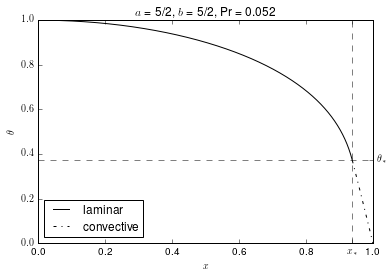

In [4]:
A = 2.5
Pr = 0.052
w = WhereAdiabatic(A=A, Pr=Pr)
Pr_crit = w.dlnOmega_dlnR**(-2)

x_max = w.x_conv_max()
if Pr < Pr_crit:
    x_lcb, y_lcb = w.xy()
    x_lcb /= x_max
    ys_laminar = np.linspace(1., y_lcb, 1000)
    xs_laminar = w._x(ys_laminar) / x_max
    ys_conv = np.linspace(y_lcb, 0, 1000)
else:
    x_lcb, y_lcb = 0, 1
    ys_conv = np.linspace(1.,    0., 1000)
    
xs_conv = w.x_adiab_func()(ys_conv) / x_max

print('Border x = {}'.format(x_lcb))
print('Border y = {}'.format(y_lcb))
print('Border rho = {}'.format(w.rho_func()([1, y_lcb])[-1]))

plt.cla()
plt.title(r'$a$ = {0}, $b$ = {0}, Pr = {1}'.format(Fraction(A), Pr))
plt.xlabel(r'$x$')
plt.ylabel(r'$\theta$')
if Pr < Pr_crit:
    plt.plot(
        xs_laminar, ys_laminar,
        'k-', linewidth=1,
        label='laminar',
    )
#     plt.plot(
#     xs_laminar, w.rho_func()(ys_laminar) * ys_laminar,
#     'k-', linewidth=1,
#     label=r'laminar $p$',
#     )
plt.plot(
    xs_conv, ys_conv,
    'k-.', linewidth=1,
    label='convective',
)
# plt.plot(
#     xs_conv, w.rho_conv_func()(ys_conv) * ys_conv,
#     'k--', linewidth=1,
#     label=r'convective $p$',
# )
plt.plot(
    [x_lcb, x_lcb], [0,1],
    'k--', linewidth='0.5',
)
plt.plot(
    [0, 1], [y_lcb, y_lcb],
    'k--', linewidth='0.5',
)
plt.xticks(
    plt.xticks()[0].tolist() + [x_lcb],
    list(map(str,plt.xticks()[0])) + [r'$x_*$']
)
plt.legend(loc='best')
ax = plt.twinx()
ax.set_yticks( (y_lcb,) )
ax.set_yticklabels( (r'$\theta_*$',) )
# plt.yticks(
#     plt.yticks()[0].tolist() + [y_lcb],
#     list(map(str,plt.yticks()[0])) + [r'$\theta^*$']
# )

if SAVEFIGS:
    plt.savefig('microcond_a{}_Pr{}.eps'.format(A, Pr))

## Plot semiheight of laminar zone for different Prandtl numbers

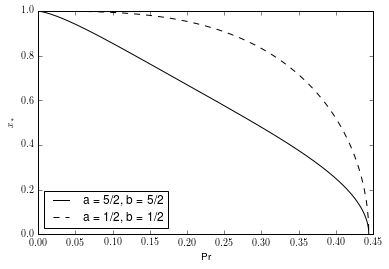

In [5]:
n = 1000

A = np.array([2.5, 0.5])
Pr = np.linspace(0, 4/9., n)

plt.cla()
plt.xlabel('Pr')
plt.ylabel('$x_*$')

xy_adiab = np.empty( (n, 2,) )
for j in range(A.shape[0]):
    for i in range(n):
        w = WhereAdiabatic(A=A[j], Pr=Pr[i])
        xy_adiab[i] = w.xy() / np.array([w.x_conv_max(),1.])
    plt.plot(
        Pr, xy_adiab[:,0],
        'k'+'-'*(j+1),
        label=r'a = {0}, b = {0}'.format(Fraction(A[j]))
    )

plt.legend(loc=0)    
    
if SAVEFIGS:
    plt.savefig('xlcb_Pr.eps')

## Plot semiheight parameter xi as a function of Pr

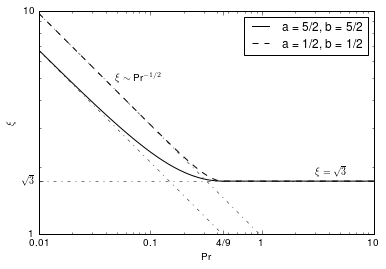

In [6]:
n = 1000

Pr = np.logspace(-2, 1, n)
A = (2.5, 0.5)

plt.cla()
plt.xscale('log')
plt.yscale('log')
plt.ylim((1, 10))
plt.xticks(
    (0.01, 0.1, 4./9., 1, 10),
    (0.01, 0.1, '4/9', 1, 10)
)
plt.yticks(
    (1  , np.sqrt(3) , 10),
    (1, r'$\sqrt{3}$', 10)
)
plt.xlabel('Pr')
plt.ylabel(r'$\xi$')

plt.plot(
    Pr, np.sqrt(3)*np.ones_like(Pr),
    'k-.', linewidth=0.5
)
plt.annotate(r'$\xi = \sqrt{3}$', (3, 1.85))

for j in range(2):
    xi = np.empty_like(Pr)

    for i in range(n):
        w = WhereAdiabatic(A=A[j], Pr=Pr[i])
        x_lcb, y_lcb = w.xy()
        x_max = w.x_conv_max()
        x_lcb /= x_max
        xi[i] = np.sqrt( 2 * (w.cp-1) * y_lcb / (1-x_lcb**2) )
    
    plt.plot(
        Pr, xi,
        'k' + '-'*(j+1),
        label=r'a = {0}, b = {0}'.format(Fraction(A[j])),
    )
    # plt.plot(
    #     4./9. * np.ones_like(plt.yticks()[0]), plt.yticks()[0],
    #     'k--', linewidth=0.5
    # )
    xi_asymp = np.sqrt((2*A[j]+1)/(2*Pr/(w.cp-1)*w.dlnOmega_dlnR**2)) / (A[j]+1) * w.hyp1
    plt.plot(
        Pr, xi_asymp,
        'k-.', linewidth=0.5
    )

plt.annotate(r'$\xi \sim$ Pr$^{-1/2}$', (0.04*1.2, xi_asymp[np.searchsorted(Pr, 0.04)]))
plt.legend(loc='best')

if SAVEFIGS:
    plt.savefig('xi_Pr.eps')